In [12]:
# 导入必要的库
import pandas as pd  # 用于数据处理
import numpy as np  # 用于数值计算
import json  # 用于处理JSON格式数据
# 绘图
import matplotlib.pyplot as plt  # 用于生成图表
from mplsoccer import VerticalPitch  # 专门用于足球比赛相关的图表绘制
# 统计模型拟合
import statsmodels.api as sm  # 提供广泛的统计模型
import statsmodels.formula.api as smf  # 通过公式形式拟合统计模型
# 打开数据文件
import os  # 用于操作系统相关的功能，如路径管理
import pathlib  # 用于更高层次的路径操作
import warnings  # 用于控制警告的显示

# 设置Pandas链式赋值模式为None，以忽略相关警告
pd.options.mode.chained_assignment = None
# 忽略警告信息
warnings.filterwarnings('ignore')

In [13]:
# 加载数据 - 存储到train数据框中
train = pd.DataFrame()  # 初始化一个空的数据框
# 准备空的数据框
path = os.path.join(str(pathlib.Path().resolve()), 'data', 'events','events_England.json')  # 拼接数据文件路径

# 打开JSON文件并读取数据
with open(path) as f:  # 打开指定路径的JSON文件
    data = json.load(f)  # 加载JSON数据到变量data中

# 将数据转换为Pandas DataFrame
train = pd.DataFrame(data)

# 查看数据框的基本信息，如列名、数据类型和内存占用
train.info()
ass_data = train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


In [14]:
# 从train数据框中筛选出所有射门事件
shots = train.loc[train['subEventName'] == 'Shot']

# 获取射门位置坐标并分别存储在X和Y列中
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)  # 计算射门的X坐标并转换为球场尺度（105米）
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)  # 计算射门的Y坐标并转换为球场尺度（68米）
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)  # 计算射门与球场中线（Y=50）之间的垂直距离

# 计算射门距离和角度
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)  # 使用勾股定理计算射门距离
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0,
                          np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)),
                          np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
# 计算射门角度（使用球门的宽度7.32米）

# 如果在建模过程中遇到依赖变量0和1颠倒的问题，可以将目标变量转换为object类型
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)  # 标记是否进球，'id':101表示进球事件 id = 301 为assist(助攻)

In [15]:
shot_feature = ['Angle','Distance','X','C','Y','Goal']
shots_data  = shots[shot_feature]

In [16]:
shots_data

,Angle,Distance,X,C,Y,Goal
46,0.467241,14.007655,12.60,6.12,27.88,1
62,0.453557,15.808608,15.75,1.36,35.36,0
91,1.375115,4.414703,4.20,1.36,35.36,1
128,0.274666,23.057235,19.95,11.56,22.44,0
249,0.219665,29.563872,26.25,13.60,20.40,0
...,...,...,...,...,...,...
642945,0.244517,29.595946,29.40,3.40,30.60,0
643023,0.309646,18.700898,14.70,11.56,22.44,1
643051,0.410444,15.011516,12.60,8.16,42.16,0
643055,0.461143,11.710918,8.40,8.16,25.84,0


Epoch 1, Loss: 0.3081722879512291
Epoch 2, Loss: 0.30278843309256365
Epoch 3, Loss: 0.3022499688371972
Epoch 4, Loss: 0.3002881425096703
Epoch 5, Loss: 0.3008195641478138
Epoch 6, Loss: 0.30049523077464313
Epoch 7, Loss: 0.29880398147623743
Epoch 8, Loss: 0.29921901472926843
Epoch 9, Loss: 0.2998230286636913
Epoch 10, Loss: 0.2989310428345873
Epoch 11, Loss: 0.2984287142119861
Epoch 12, Loss: 0.29871008561692647
Epoch 13, Loss: 0.29773301869278124
Epoch 14, Loss: 0.297949920375363
Epoch 15, Loss: 0.2982267286468672
Epoch 16, Loss: 0.29797417008092064
Epoch 17, Loss: 0.29825295491651055
Epoch 18, Loss: 0.2977872263011936
Epoch 19, Loss: 0.29798361937344603
Epoch 20, Loss: 0.296768983206078
Epoch 21, Loss: 0.29746715411180136
Epoch 22, Loss: 0.2967792552008608
Epoch 23, Loss: 0.29602874532760776
Epoch 24, Loss: 0.29694022902304074
Epoch 25, Loss: 0.2972015809107947
Epoch 26, Loss: 0.29680244480232165
Epoch 27, Loss: 0.29651653417799423
Epoch 28, Loss: 0.2966272055761084
Epoch 29, Loss: 0

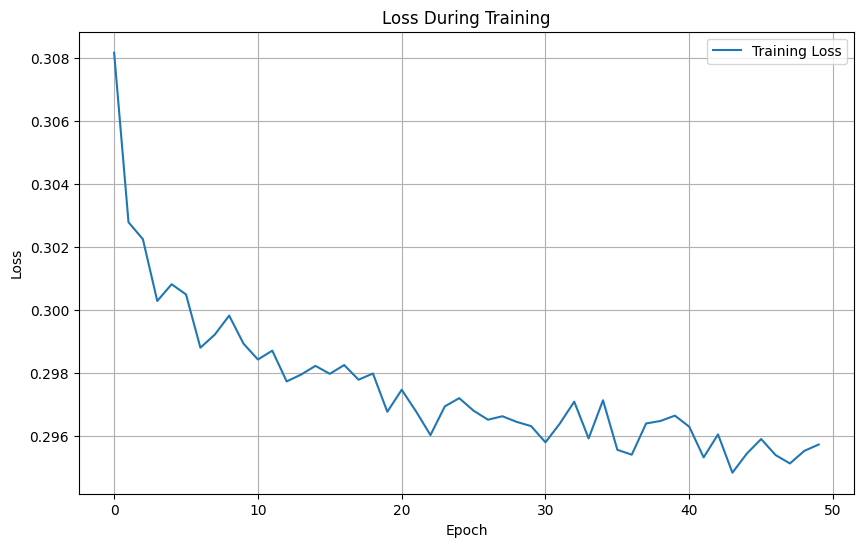

Model saved to xG_prediction_model.pth
Accuracy: 0.8953282081608516
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1509
         1.0       0.62      0.07      0.13       182

    accuracy                           0.90      1691
   macro avg       0.76      0.53      0.54      1691
weighted avg       0.87      0.90      0.86      1691

      Predicted_Probability
0                  0.183174
1                  0.147310
2                  0.325869
3                  0.158147
4                  0.062960
...                     ...
1686               0.018459
1687               0.262214
1688               0.068585
1689               0.070470
1690               0.011125

[1691 rows x 1 columns]


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
# 假设shots_data已经是我们的DataFrame，并且包含了需要的特征和目标列
features = ['Angle', 'Distance', 'X', 'C', 'Y']
# 将Pandas DataFrame的特征列转换为float32类型
X = shots_data[features].astype(np.float32).values
y = shots_data['Goal'].astype(np.float32).values  # 确保目标变量也是适当的数值类型

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据转换为torch张量
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
y_test = torch.FloatTensor(y_test).unsqueeze(1)
# 创建数据加载器
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(features), 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = Net()

# 损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 训练模型
# def train_model(num_epochs):
#     model.train()
#     for epoch in range(num_epochs):
#         for data, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# # 训练模型
# train_model(100)
# 更新训练模型函数，以记录每个epoch的损失
def train_model(num_epochs):
    model.train()
    loss_history = []  # 用来存储每个epoch的平均损失
    for epoch in range(num_epochs):
        total_loss = 0
        count = 0
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1
        average_loss = total_loss / count
        loss_history.append(average_loss)  # 保存每个epoch的平均损失
        print(f'Epoch {epoch+1}, Loss: {average_loss}')

    return loss_history

# 训练模型并记录损失历史
loss_history = train_model(50)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.grid(True)
plt.show()
model_path = 'xG_prediction_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")
# 测试模型
model.eval()
predictions = []
y_pred_list = []
for data, targets in test_loader:
    outputs = model(data)
    predicted = (outputs.data > 0.5).float()
    predictions.extend(predicted.numpy().flatten())  # 保存预测结果
    y_pred_list.extend(outputs.data.numpy().flatten())  # 保存预测概率

# 将预测概率添加到DataFrame
X_test = pd.DataFrame(X_test.numpy(), columns=features)
X_test['Predicted_Probability'] = y_pred_list

# 计算准确度和输出分类报告
print('Accuracy:', accuracy_score(y_test.numpy().flatten(), predictions))
print(classification_report(y_test.numpy().flatten(), predictions))

# 输出包含预测概率的DataFrame
print(X_test[['Predicted_Probability']])

In [18]:
# 定义模型架构，必须与保存时使用的架构相同
model = Net()

# 加载保存的模型
model.load_state_dict(torch.load(model_path))
model.eval()  # 将模型设置为评估模式

print("Model loaded and ready for use!")

Model loaded and ready for use!
